In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras .models import Sequential
from tensorflow.keras .layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras .optimizers import SGD
import math
from sklearn.metrics import mean_absolute_percentage_error

#!pip install tensorflow

2022-09-12 17:05:55.381414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 17:05:56.064112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 17:05:56.064176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-12 17:05:56.178447: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-12 17:05:58.154564: W tensorflow/stream_executor/platform/de

In [2]:
# Some functions to help out with
def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    plt.plot(df_plot,label=['Actual Consumption','Predicted Consumption'])
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percenatge error is {}.".format(mape))

In [3]:
acorn_group="A"
tariff='Std'
dataset = pd.read_csv(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{acorn_group}_avg_{tariff}_v1.csv', index_col='DateTime', parse_dates=['DateTime'])
dataset.drop(columns='Unnamed: 0',inplace=True)
dataset

,KWH/hh,tariff
DateTime,,
2012-01-01 00:00:00,0.495875,Std
2012-01-01 00:30:00,0.506625,Std
2012-01-01 01:00:00,0.470625,Std
2012-01-01 01:30:00,0.392375,Std
2012-01-01 02:00:00,0.477750,Std
...,...,...
2014-02-27 22:00:00,0.598800,Std
2014-02-27 22:30:00,0.571820,Std
2014-02-27 23:00:00,0.511040,Std


In [4]:
df=dataset[['KWH/hh']]
#df.reset_index(inplace=True)
df

,KWH/hh
DateTime,
2012-01-01 00:00:00,0.495875
2012-01-01 00:30:00,0.506625
2012-01-01 01:00:00,0.470625
2012-01-01 01:30:00,0.392375
2012-01-01 02:00:00,0.477750
...,...
2014-02-27 22:00:00,0.598800
2014-02-27 22:30:00,0.571820
2014-02-27 23:00:00,0.511040


In [5]:
# Checking for missing values
training_set = df[:'2013'].loc[:,['KWH/hh']].values
test_set = df['2014':].loc[:,['KWH/hh']].values
training_set

array([[0.495875  ],
       [0.506625  ],
       [0.470625  ],
       ...,
       [0.59709804],
       [0.60901961],
       [0.58235295]])

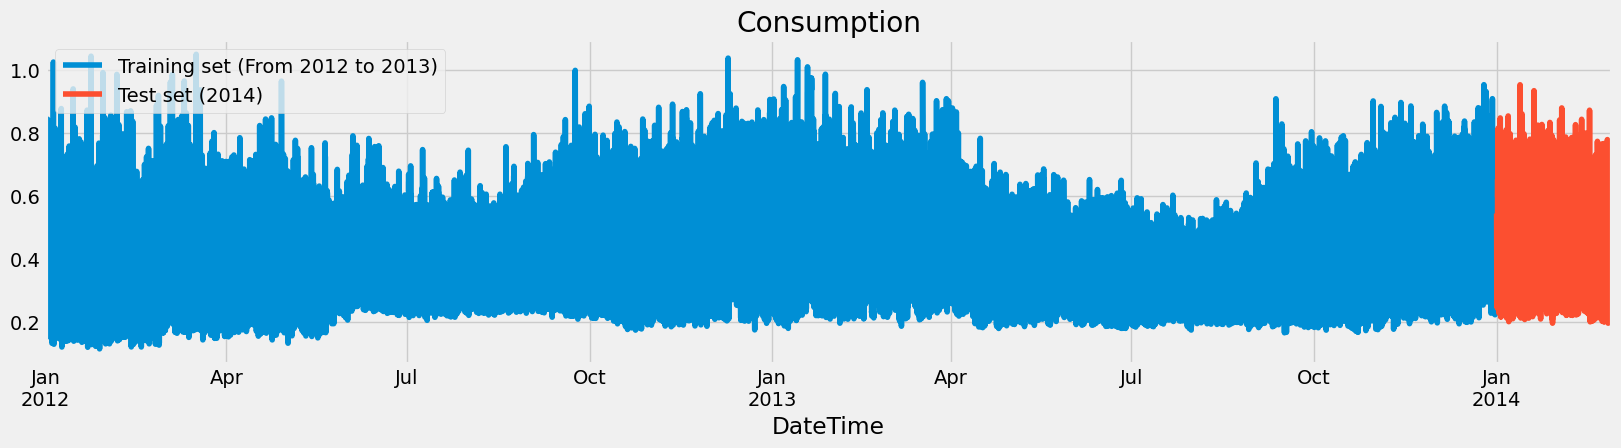

In [6]:
df["KWH/hh"][:'2013'].plot(figsize=(18,4),legend=True)
df["KWH/hh"]['2014':].plot(figsize=(18,4),legend=True)
plt.legend(['Training set (From 2012 to 2013)','Test set (2014)'])
plt.title('Consumption')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

2022-09-12 17:06:03.220055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-12 17:06:03.220181: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-12 17:06:03.220249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Zenan-ABC): /proc/driver/nvidia/version does not exist
2022-09-12 17:06:03.220744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='MeanAbsolutePercentageError')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32,verbose=1)

Epoch 1/10
85/85 [==============================] - 27s 228ms/step - loss: 25232.1719
Epoch 2/10
85/85 [==============================] - 25s 289ms/step - loss: 16072.7354
Epoch 3/10
85/85 [==============================] - 20s 234ms/step - loss: 30489.7188
Epoch 4/10
85/85 [==============================] - 20s 230ms/step - loss: 25656.2598
Epoch 5/10
85/85 [==============================] - 18s 215ms/step - loss: 17676.5410
Epoch 6/10
85/85 [==============================] - 23s 268ms/step - loss: 32886.0859
Epoch 7/10
85/85 [==============================] - 25s 294ms/step - loss: 22705.7363
Epoch 8/10
85/85 [==============================] - 24s 285ms/step - loss: 22957.2070
Epoch 9/10
85/85 [==============================] - 24s 279ms/step - loss: 16439.8965
Epoch 10/10
85/85 [==============================] - 20s 233ms/step - loss: 8686.0049


In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entries of test set have 60 previous values which is impossible to get 

dataset_total = pd.concat((df["KWH/hh"][:'2013'],df["KWH/hh"]['2014':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [12]:
# Preparing X_test and predicting the consumption
X_test = []
for i in range(60,2845):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_consumption = regressor.predict(X_test)
predicted_consumption = sc.inverse_transform(predicted_consumption)

88/88 [==============================] - 7s 59ms/step


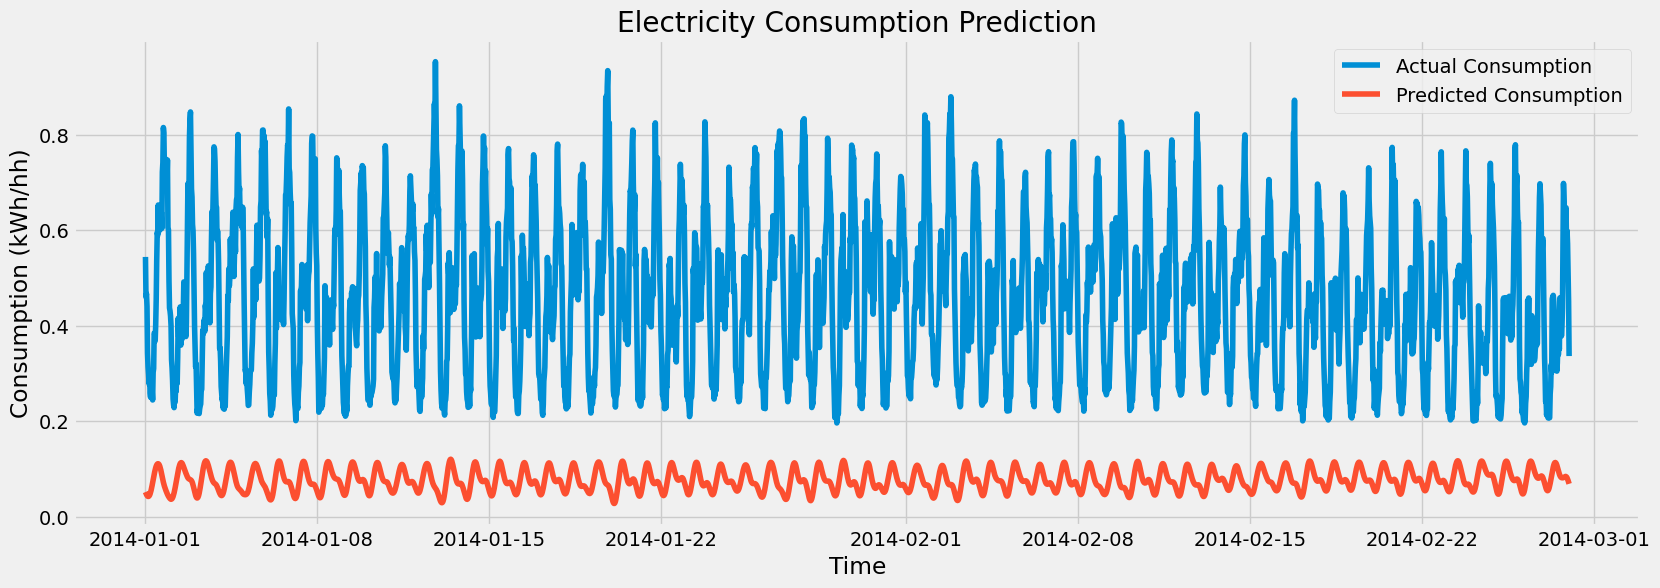

The  mean absolute percenatge error is 0.8172147524886859.


In [14]:
# Visualizing the results for LSTM
df_plot=df['2014':].copy()
df_plot.rename(columns={'KWH/hh':'Test'},inplace=True)
df_plot['Predicted']=predicted_consumption
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_set,predicted_consumption)